👇 **Do not change the code in this cell.** If you're working in Google Colab, you can run this cell to install `category_encoders`.

In [25]:
%%capture
import sys

if 'google.colab' in sys.modules:
    # Install packages in Colab
    !pip install category_encoders


# Sprint Challenge: Predict Steph Curry's Shots 🏀

For your Sprint Challenge, you'll use a dataset with all Steph Curry's NBA field goal attempts from October 2009 through June 2019 (regular season and playoffs). The dataset was collected with the [nba_api](https://github.com/swar/nba_api) Python library.

You'll create a model to predict whether Curry will make a shot based on his past perfomance.

# Directions

This notebook contains 10 tasks, which cover the material we've learned in this sprint. Here's a summary:

- **Task 1:** Importing data.
- **Task 2:** Feature engineering.
- **Task 3:** Splitting data into a feature matrix and target vector.
- **Task 4:** Splitting data into training, validation, and test sets.
- **Task 5:** Establishing baseline accuracy.
- **Task 6:** Building a model with a transformer and a tree-based predictor.
- **Task 7:** Calculating training and validation accuracy.
- **Task 8 (`stretch goal`):** Tuning model hyperparameters.
- **Task 9:** Calculating precision and recall from a confusion matrix.
- **Task 10 (`stretch goal`):** Plotting a confusion matrix.

For each task you should do the following:

- Read the task instructions.
- Write your code in the cell below the task. Delete the `raise
NotImplementedError` before your start.
- Run the testing cell below the task. If you get an error, read the error message and re-evaluate your code.

**You should limit your code to the following libraries:**

- `category_encoders`
- `numpy`
- `matplotlib`
- `pandas`
- `sklearn`



# I. Wrangle Data

**Task 1:** Change the code below to import your dataset. Be sure to examine the columns carefully and determine if one of them should be set at the index.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from category_encoders import OrdinalEncoder

In [26]:
'''T1. Import DataFrame `df`'''

import pandas as pd
url = 'https://drive.google.com/uc?export=download&id=1fL7KPyxgGYfQDsuJoBWHIWwCAf-HTFpX'
df = pd.read_csv(url)

In [27]:
df.head()

,game_id,game_event_id,player_name,period,minutes_remaining,seconds_remaining,action_type,shot_type,shot_zone_basic,shot_zone_area,shot_zone_range,shot_distance,loc_x,loc_y,shot_made_flag,game_date,htm,vtm,season_type,scoremargin_before_shot
0,20900015,4,Stephen Curry,1,11,25,Jump Shot,3PT Field Goal,Above the Break 3,Right Side Center(RC),24+ ft.,26,99,249,0,2009-10-28,GSW,HOU,Regular Season,2.0
1,20900015,17,Stephen Curry,1,9,31,Step Back Jump shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,18,-122,145,1,2009-10-28,GSW,HOU,Regular Season,0.0
2,20900015,53,Stephen Curry,1,6,2,Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),8-16 ft.,14,-60,129,0,2009-10-28,GSW,HOU,Regular Season,-4.0
3,20900015,141,Stephen Curry,2,9,49,Jump Shot,2PT Field Goal,Mid-Range,Left Side(L),16-24 ft.,19,-172,82,0,2009-10-28,GSW,HOU,Regular Season,-4.0
4,20900015,249,Stephen Curry,2,2,19,Jump Shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,16,-68,148,0,2009-10-28,GSW,HOU,Regular Season,0.0


In [28]:
df.shape

(13958, 20)

In [29]:
type(df['game_date'][0])

str

In [30]:
df['game_date'] = pd.to_datetime(df['game_date'])

In [31]:
type(df['game_date'][0])

pandas._libs.tslibs.timestamps.Timestamp

In [32]:
df.set_index('game_date', inplace=True)

In [33]:
type(df.index)

pandas.core.indexes.datetimes.DatetimeIndex

In [34]:
len(df)

13958

**Task 1 Testing**

In [ ]:
'''T1 Testing'''

assert isinstance(df, pd.DataFrame), 'Have you created a DataFrame named `df`?'
assert len(df) == 13958, 'Is `df` the correct length?'


**Task 2a:** Engineer at least 1 new feature. You can use something from the list below or your own idea.

- **Homecourt Advantage**: Is the home team (`htm`) the Golden State Warriors (`GSW`) ?
- **Opponent**: Who is the other team playing the Golden State Warriors?
- **Seconds remaining in the period**: Combine minutes remaining with seconds remaining, to get the total number of seconds remaining in the period.
- **Seconds remaining in the game**: Combine period, and seconds remaining in the period, to get the total number of seconds remaining in the game. A basketball game has 4 periods, each 12 minutes long.
- **Made previous shot**: Was Steph Curry's previous shot successful?

**Task 2b (`stretch goal — optional`):** Create a total of 3 new features, using your own ideas or the list above. Make sure you're not just duplicating features that are already in the feature matrix.

In [18]:
"""T2. Create new feature"""

df.columns

Index(['game_id', 'game_event_id', 'player_name', 'period',
       'minutes_remaining', 'seconds_remaining', 'action_type', 'shot_type',
       'shot_zone_basic', 'shot_zone_area', 'shot_zone_range', 'shot_distance',
       'loc_x', 'loc_y', 'shot_made_flag', 'htm', 'vtm', 'season_type',
       'scoremargin_before_shot'],
      dtype='object')

In [35]:
df.shape

(13958, 19)

In [36]:
df['homecourt_advantage'] = df['htm'].apply(lambda x: 1 if x == 'GSW' else 0)
df['seconds_remaining_period'] = df['minutes_remaining'] * 60 + df['seconds_remaining']
df['seconds_remaining_game'] = ((4-df['period'])*12*60) + df['minutes_remaining'] * 60 + df['seconds_remaining']

In [37]:
df.columns

Index(['game_id', 'game_event_id', 'player_name', 'period',
       'minutes_remaining', 'seconds_remaining', 'action_type', 'shot_type',
       'shot_zone_basic', 'shot_zone_area', 'shot_zone_range', 'shot_distance',
       'loc_x', 'loc_y', 'shot_made_flag', 'htm', 'vtm', 'season_type',
       'scoremargin_before_shot', 'homecourt_advantage',
       'seconds_remaining_period', 'seconds_remaining_game'],
      dtype='object')

In [38]:
df.shape

(13958, 22)

**Task 2 Test**

In [ ]:
'''T2 Testing'''

assert df.shape[1] >= 20, '`df` does not appear to have new features.'


# II. Split Data

**Task 3:** Divide the DataFrame `df` into the feature matrix `X` and the target vector `y`. Your target is `'shot_made_flag'`.

In [39]:
'''T3. Create `X` and `y`.'''
target = 'shot_made_flag'
y = df[target]
X = df.drop(columns=target)
print('Baseline Accuracy Score: ', df[target].value_counts(normalize=True).max())

Baseline Accuracy Score:  0.5270812437311936


In [40]:
y.shape, X.shape

((13958,), (13958, 21))

**Task 3 Test**

In [ ]:
'''T3 Tests'''

assert y.shape == (13958,), '`y` either has the wrong number of rows, or is two-dimentional.'
assert len(X) == 13958, '`X` has the wrong number of rows.'
assert X.shape[1] > 1, '`X` has the wrong number of columns'
assert 'shot_made_flag' not in X.columns, 'Target is still part of feature matrix.'

**Task 4:** Divide your dataset into training, validation, and test sets.

- Your training set (`X_train`, `y_train`) should contain games from the 2009-10 season through the end of the 2016-17 season.
- Your validation set (`X_val`, `y_val`) should contain games from the 2017-18 season.
- Your test set (`X_test`, `y_test`) should contain games from the 2018-2019 season.
- **Tip:** The NBA season begins in October and ends in June.

In [45]:
#one way
# mask_train = X.index < '2017-07-01'
# mask_test = X.index > '2018-10-01'
# mask_val = (X.index > '2017-10-01') & (X.index < '2018-09-01')
# X_train, y_train = X[mask_train], y[mask_train]
# X_test, y_test = X[mask_test], y[mask_test]
# X_val, y_val = X[mask_val], y[mask_val]
# X_train.shape, X_val.shape, X_test.shape

((11081, 21), (1168, 21), (1709, 21))

In [41]:
'''T4. Create training and val'''
# another way
cutoff = '2017-10-01'
cut2 = '2018-10-01'

X_train, y_train = X.loc[(X.index < cutoff)], y.loc[X.index < cutoff]
X_val, y_val = X.loc[(X.index > cutoff) & (X.index < cut2)], y.loc[(X.index > cutoff) & (X.index < cut2)]
X_test, y_test = X.loc[X.index > cut2], y.loc[X.index > cut2]

X_train.shape, X_val.shape, X_test.shape

((11081, 21), (1168, 21), (1709, 21))

**Test 4**

In [ ]:
'''T4 Tests'''
assert len(X_train) == len(y_train) == 11081
assert len(X_val) == len(y_val) == 1168
assert len(X_test) == len(y_test) == 1709


# III. Establish Baseline

**Task 5:** Establish the baseline accuracy score for this classification problem using your training set. Save the score to the variable `baseline_acc`.

In [46]:
'''T5. Calculate baseline accuracy `baseline_acc`.'''

# YOUR CODE HERE
baseline_acc = y_train.value_counts(normalize=True).max()
print('Baseline Accuracy:', baseline_acc)

Baseline Accuracy: 0.5272087356736757


**Task 5 Testing**

In [ ]:
'''T5 Testing'''

assert isinstance(baseline_acc, float)
assert 0.0 <= baseline_acc <= 1.0


# IV. Build Model

**Task 6:** Build a model that includes (1) a transformer for categorical features and (2) a tree-based predictor. You should combine these two components (and any other pieces you think are necessary) in a pipeline named `model`. Be sure to fit your model to your training data.

In [47]:
'''T6. Build a pipeline `model` with encoder and tree-based predictor.'''
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
# YOUR CODE HERE
model = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy='mean'),
    RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42))

model.fit(X_train, y_train);

**Task 6 Testing**

In [ ]:
'''T6 Testing'''

from sklearn.pipeline import Pipeline
assert isinstance(model, Pipeline), '`model` should be type `Pipeline`.'

# Does `model` Pipeline have multiple components?
assert len(model.named_steps.keys()) > 1, '`model` should have more than one component.'

# Has `model` been trained?
assert hasattr(model, 'classes_'), 'Have you trained `model`?'


# V. Check Metrics

**Task 7:** Check the training and validation accuracy of your model, and assign the scores to `train_acc` and `val_acc` respectively.

In [48]:
'''T7. Calculate train and test accuracy.'''

# YOUR CODE HERE
train_acc = model.score(X_train, y_train)
val_acc = model.score(X_val, y_val)
print('Training Accuracy Score:', train_acc)
print('Validation Accuracy Score:', val_acc)

Training Accuracy Score: 1.0
Validation Accuracy Score: 0.5958904109589042


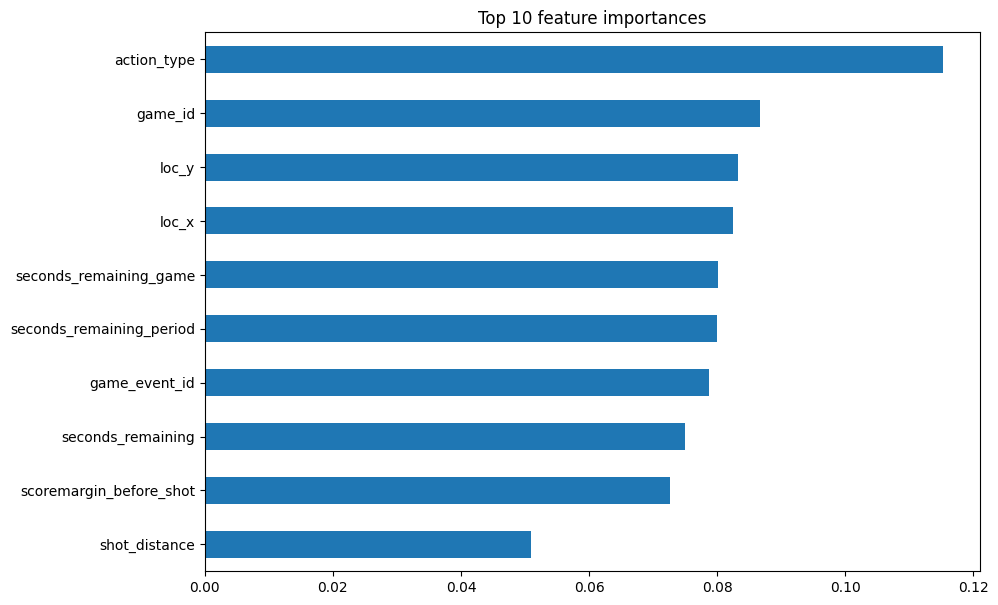

In [50]:
rf = model.named_steps['randomforestclassifier']
importances = pd.Series(rf.feature_importances_, X_train.columns)
n = 10
plt.figure(figsize=(10,7))
plt.title(f'Top {n} feature importances')
importances.sort_values()[-n:].plot.barh();

**Task 7 Test**

In [ ]:
'''T7 Testing'''

# Is `training_acc` a float between 0.0 and 1.0?
assert isinstance(train_acc, float)
assert 0.0 <= train_acc <= 1.0

# Is `validation_acc` a float between 0.0 and 1.0?
assert isinstance(val_acc, float)
assert 0.0 <= val_acc <= 1.0


# VI. Tune Model

**Task 8 (`stretch goal — optional`):** Using your training and validation sets as a guide, tune the hyperparameters of your model to see if you can improve its accuracy. You can perform your tuning "by hand" or using [`RandomizedSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html).

- Important hyperparameters for all tree-based models: `max_depth`.
- Important hyperparameters for random forest models: `n_estimators`, `max_samples`.
- Important hyperparametes for gradient boosting tree models: `n_estimators`, `learning_rate`.
- **TIP:** If you use `RandomizedSearchCV`, set `n_iter` to `3`. Any larger and the auto-grader will stop working.
- **TIP:** Since you already created a validation set above, there is no need to do k-fold cross-validation here. Set `cv` to `None`.

Once you're satisfied with your model's performance on the validation set (if you can get above `0.6`, you're doing good), calculate its accuracy with your test set. Assign the result to `test_acc`.

In [56]:
'''T8. Tune model.'''
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import randint, uniform

param_distributions = {
    'randomforestclassifier__n_estimators':[50,80,100,150,200],
    'randomforestclassifier__min_samples_leaf':[1,2,4],
    'randomforestclassifier__max_features':['auto','sqrt'],
    'randomforestclassifier__min_samples_split':[2,5,10]
}
search = RandomizedSearchCV(
    model,
    param_distributions,
    n_iter=3,
    scoring='accuracy',
    verbose=10,
    cv=None,
    return_train_score=True,
    n_jobs=-1
)

search.fit(X_train,y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


RandomizedSearchCV(estimator=Pipeline(steps=[('ordinalencoder',
                                              OrdinalEncoder(cols=['player_name',
                                                                   'action_type',
                                                                   'shot_type',
                                                                   'shot_zone_basic',
                                                                   'shot_zone_area',
                                                                   'shot_zone_range',
                                                                   'htm', 'vtm',
                                                                   'season_type'],
                                                             mapping=[{'col': 'player_name',
                                                                       'data_type': dtype('O'),
                                                                       'mapping': Stephen Curry    1
NaN             -2
dtype: int64},
                                                                      {'col': 'action_type',
                                                                       'data_type': dtype('O'),
                                                                       'mapping...
                                              RandomForestClassifier(n_jobs=-1,
                                                                     random_state=42))]),
                   n_iter=3, n_jobs=-1,
                   param_distributions={'randomforestclassifier__max_features': ['auto',
                                                                                 'sqrt'],
                                        'randomforestclassifier__min_samples_leaf': [1,
                                                                                     2,
                                                                                     4],
                                        'randomforestclassifier__min_samples_split': [2,
                                                                                      5,
                                                                                      10],
                                        'randomforestclassifier__n_estimators': [50,
                                                                                 80,
                                                                                 100,
                                                                                 150,
                                                                                 200]},
                   return_train_score=True, scoring='accuracy', verbose=10)

In [60]:
train_acc = search.score(X_train, y_train)
val_acc = search.score(X_val, y_val)
test_acc = search.score(X_test, y_test)
print('Training Accuracy Score:', train_acc)
print('Validation Accuracy Score:', val_acc)
print('Test Accuracy Score:', test_acc)

Training Accuracy Score: 0.9296092410432272
Validation Accuracy Score: 0.6053082191780822
Test Accuracy Score: 0.6372147454651843


In [58]:
print('Best hyperparameters', search.best_params_)
print('Cross-validation MAE', -search.best_score_)

Best hyperparameters {'randomforestclassifier__n_estimators': 80, 'randomforestclassifier__min_samples_split': 5, 'randomforestclassifier__min_samples_leaf': 4, 'randomforestclassifier__max_features': 'auto'}
Cross-validation MAE -0.6415473067484763


**Task 8 Testing**

In [ ]:
'''T8 Testing'''
assert isinstance(test_acc, float)
assert 0.0 <= test_acc <= 1.0

# VII. Communication

**Task 9:** Below is a confusion matrix for the model that your instructor made for this challenge (based on the **test data**). Calculate the precision and recall of this model, naming them `instructor_precision` and `instructor_recall`, respectively.

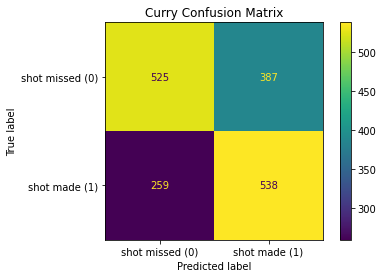

In [61]:
'''T9. Calculate precision and recall'''
# YOUR CODE HERE
instructor_precision = 538 / (538 + 387)
instructor_recall = 538 / (538 + 259)
print('Instuctor model precision', instructor_precision)
print('Instuctor model recall', instructor_recall)

Instuctor model precision 0.5816216216216217
Instuctor model recall 0.6750313676286073


**Task 9 Testing**

In [ ]:
'''T9 Testing'''
assert isinstance(instructor_precision, float)
assert isinstance(instructor_recall, float)
assert 0 <= instructor_precision <= 1
assert 0 <= instructor_recall <= 1

**Task 10 (`stretch goal — optional`):** Plot confusion matrix for your model using your **test data**.

This task will not be autograded - but it is part of completing the challenge.

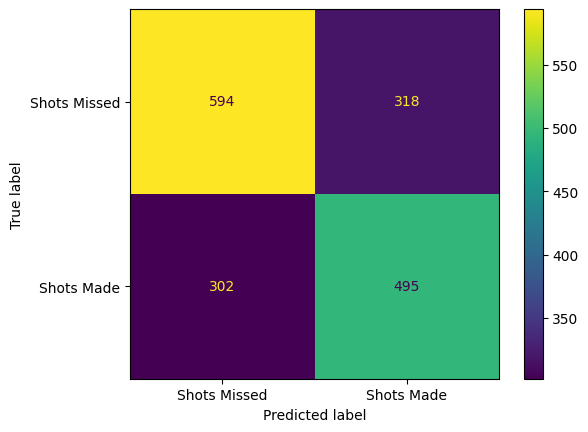

In [67]:
'''T10. Plot ROC curve.'''
# YOUR CODE HERE
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
ConfusionMatrixDisplay.from_estimator(search, X_test, y_test,display_labels = ['Shots Missed', 'Shots Made'])

In [64]:
print(classification_report(y_test, search.predict(X_test)))

              precision    recall  f1-score   support

           0       0.66      0.65      0.66       912
           1       0.61      0.62      0.61       797

    accuracy                           0.64      1709
   macro avg       0.64      0.64      0.64      1709
weighted avg       0.64      0.64      0.64      1709



In [66]:
sk_precision = 495 / (495 + 318)
sk_recall = 495  / (495 + 302)
print('SK model precision', sk_precision)
print('SK model recall', sk_recall)

SK model precision 0.6088560885608856
SK model recall 0.6210790464240903
